In [1]:
import seml
import pandas as pd
import glob
import muon as mu
import deconvatac as de

/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = seml.get_results('cell2loc_heart', to_data_frame=True)

100%|██████████| 3/3 [00:00<00:00, 342.03it/s]


* output real paths that we can read
* have everything in one table
* have a dataset identifier (e.g. Heart1)
* have a model identifier/name
* whether you used atac or rna

In [64]:
res = pd.read_csv(glob.glob("/vol/storage/data/deconvolution_results/Cell2Location/Heart3_atac" + "/*")[0], index_col=0)

In [65]:
res.columns = res.columns.to_series().str.split("q05cell_abundance_w_sf_", expand=True).loc[:, 1].values
res.index = res.index.astype(str)

In [40]:
heart1 = mu.read(df['config.data.adata_spatial_path'][0])

In [67]:
heart3 = mu.read(df["config.data.adata_spatial_path"][2])

In [69]:
def get_proportions(adata):
    df = pd.DataFrame(adata.obsm["proportions"], columns=adata.uns["proportion_names"], index=adata.obs_names)
    return df

In [70]:
targets = get_proportions(heart3)

In [71]:
targets

,Adipocyte,Atrial Cardiomyocyte,Endothelial cell,Fibroblast,Lymphatic Endothelial cell,Lymphoid,Mast cell,Mesothelial cell,Mural cell,Myeloid,Neural cell,Ventricular Cardiomyocyte
0,0.0,0.0,0.142857,0.071429,0.142857,0.071429,0.071429,0.071429,0.071429,0.142857,0.071429,0.142857
1,0.0,0.0,0.000000,0.000000,0.071429,0.142857,0.142857,0.214286,0.142857,0.000000,0.142857,0.142857
2,0.0,0.0,0.000000,0.066667,0.266667,0.000000,0.066667,0.133333,0.066667,0.200000,0.133333,0.066667
3,0.0,0.0,0.230769,0.000000,0.153846,0.076923,0.000000,0.230769,0.000000,0.000000,0.076923,0.230769
4,0.0,0.0,0.133333,0.133333,0.000000,0.066667,0.066667,0.133333,0.066667,0.000000,0.200000,0.200000
...,...,...,...,...,...,...,...,...,...,...,...,...
956,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.400000,0.000000,0.400000
957,0.2,0.0,0.000000,0.000000,0.000000,0.000000,0.400000,0.200000,0.000000,0.200000,0.000000,0.000000
958,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000
959,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.600000,0.200000,0.000000,0.000000,0.000000,0.200000


In [72]:
res = res.div(res.sum(axis=1), axis=0)

In [73]:
res.loc[targets.index, targets.columns] - targets

,Adipocyte,Atrial Cardiomyocyte,Endothelial cell,Fibroblast,Lymphatic Endothelial cell,Lymphoid,Mast cell,Mesothelial cell,Mural cell,Myeloid,Neural cell,Ventricular Cardiomyocyte
0,0.000689,0.000811,-0.119908,-0.001227,-0.003682,0.091445,-0.064323,-0.035086,0.101227,0.126433,-0.014729,-0.081650
1,0.000282,0.000273,0.010674,0.028768,0.053968,-0.034911,-0.142318,0.003819,0.028867,0.106792,0.076778,-0.132992
2,0.026429,0.043356,0.129214,-0.050907,0.123215,0.017382,0.018902,-0.069197,-0.064997,-0.098253,-0.083283,0.008140
3,0.000162,0.000977,0.012223,0.000162,-0.151781,-0.014517,0.000037,-0.008108,0.000287,0.000591,0.130775,0.029192
4,0.002121,0.002436,-0.051927,0.002701,0.000823,-0.054985,-0.066425,-0.043745,-0.023069,0.000652,-0.139613,0.371032
...,...,...,...,...,...,...,...,...,...,...,...,...
956,0.001921,0.083649,0.030373,0.000621,0.001249,0.009037,0.014784,-0.174122,0.036846,-0.065016,0.001547,0.059110
957,-0.141796,0.000443,0.003303,0.000303,0.014415,0.016107,0.183706,-0.175542,0.000668,0.092654,0.000613,0.005126
958,0.000023,0.000005,0.000219,0.000061,0.000042,0.019543,-0.039899,-0.233547,0.000040,0.253458,0.000052,0.000002
959,0.001239,0.000628,0.000185,0.000461,0.000094,0.022346,-0.182172,0.168397,0.000160,0.001229,0.000265,-0.012833


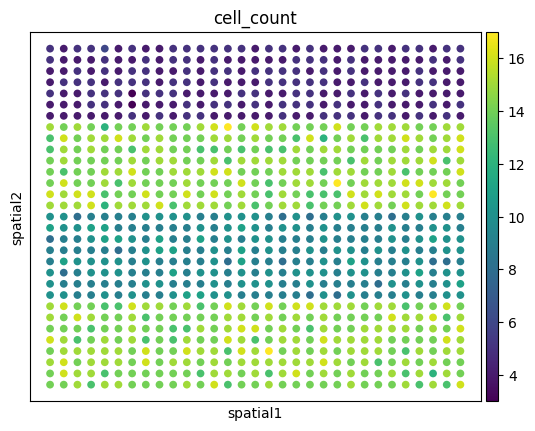

In [79]:
import scanpy as sc
sc.pl.embedding(heart3, basis='spatial', color='cell_count')

In [82]:
heart3.obs = heart3.obs.join(targets).join(res, rsuffix="_deconv")

In [89]:
targets

,Adipocyte,Atrial Cardiomyocyte,Endothelial cell,Fibroblast,Lymphatic Endothelial cell,Lymphoid,Mast cell,Mesothelial cell,Mural cell,Myeloid,Neural cell,Ventricular Cardiomyocyte
0,0.0,0.0,0.142857,0.071429,0.142857,0.071429,0.071429,0.071429,0.071429,0.142857,0.071429,0.142857
1,0.0,0.0,0.000000,0.000000,0.071429,0.142857,0.142857,0.214286,0.142857,0.000000,0.142857,0.142857
2,0.0,0.0,0.000000,0.066667,0.266667,0.000000,0.066667,0.133333,0.066667,0.200000,0.133333,0.066667
3,0.0,0.0,0.230769,0.000000,0.153846,0.076923,0.000000,0.230769,0.000000,0.000000,0.076923,0.230769
4,0.0,0.0,0.133333,0.133333,0.000000,0.066667,0.066667,0.133333,0.066667,0.000000,0.200000,0.200000
...,...,...,...,...,...,...,...,...,...,...,...,...
956,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.400000,0.000000,0.400000
957,0.2,0.0,0.000000,0.000000,0.000000,0.000000,0.400000,0.200000,0.000000,0.200000,0.000000,0.000000
958,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000
959,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.600000,0.200000,0.000000,0.000000,0.000000,0.200000


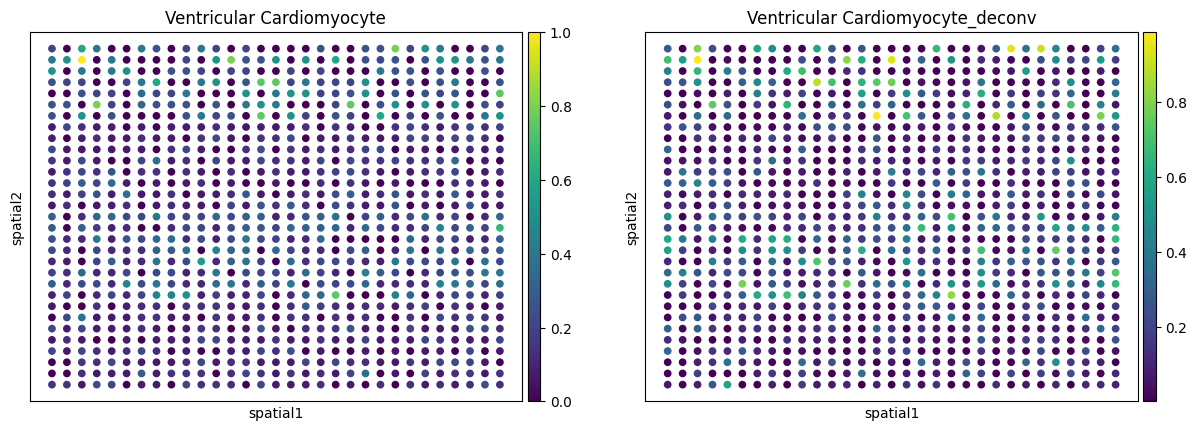

In [90]:
sc.pl.embedding(heart3, basis="spatial", color=["Ventricular Cardiomyocyte", "Ventricular Cardiomyocyte_deconv"])

In [74]:
de.tl.jsd(res, targets)

0.3505466623129243

In [75]:
de.tl.rmse(res, targets)

0.08793804925931659